# Imports

In [1]:
from Twitter import TwitterAccess
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from collections import Counter
pd.options.display.max_colwidth = None
import nltk
import string
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from spellchecker import SpellChecker
import random
import numpy as np
from multiprocessing import  Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin # ???
from sklearn.utils.validation import check_X_y, check_is_fitted # ???
from scipy import sparse #???
from sklearn.linear_model import LogisticRegression



[nltk_data] Downloading package stopwords to /u/arsaikia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Architecture

In [2]:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def pr(self, x, y_i, y):
        p = x[y==y_i].sum(0)
        return (p+1) / ((y==y_i).sum()+1)
    
    def fit(self, x, y):
        # Check that X and y have correct shape
#         y = y
        x, y = check_X_y(x, y, accept_sparse=True)
        self._r = sparse.csr_matrix(np.log(self.pr(x,1,y) / self.pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs, solver ='liblinear').fit(x_nb, y)
        self.coef_ = self._clf.coef_
        return self

# Train-Validate

In [3]:

def train_validate(X, y, min_df):
    le = LabelEncoder()
    y = le.fit_transform(y)

    tfv = TfidfVectorizer(tokenizer=nltk.casual_tokenize, min_df=min_df,  max_features=30000, 
                strip_accents='unicode', analyzer='word',ngram_range=(1,3),
                use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')
    X = tfv.fit_transform(X).tocsr()

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    

    model = NbSvmClassifier(C=1, dual=True, n_jobs=1)

    model.fit(X_train, y_train)
    preds_valid = model.predict(X_valid)
#     proba_valid = model.predict_proba(X_valid)[:,1]
    preds_train = model.predict(X_train)
#     proba_train = model.predict_proba(X_train)[:,1]


    print(classification_report(y_train, preds_train))
    try:
        print('AUC: ',  roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    except:
        print('AUC: ',  roc_auc_score(y_train, model.predict_proba(X_train), multi_class ='ovr'))
        
    print(classification_report(y_valid, preds_valid))
    try:
        print('AUC: ',  roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1]))
    except:
        print('AUC: ',  roc_auc_score(y_valid, model.predict_proba(X_valid), multi_class ='ovr'))
    return model, tfv


# Test

In [4]:
def test(X, y, X_test,y_test,min_df):
    le = LabelEncoder()
    y = le.fit_transform(y)

    tfv = TfidfVectorizer(tokenizer=nltk.casual_tokenize, min_df=min_df,  max_features=30000, 
                strip_accents='unicode', analyzer='word',ngram_range=(1,3),
                use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')
    X = tfv.fit_transform(X).tocsr()

    model = NbSvmClassifier(C=1, dual=True, n_jobs=1)

    model.fit(X, y)

    y_test = le.transform(y_test)
    X_test = tfv.transform(X_test).tocsr()

    print(X_test.shape, y_test.shape)
    preds_test = model.predict(X_test)
#     proba_test = model.predict_proba(X_test)[:,1]


    print(classification_report(y_test, preds_test))
    try:
        print('AUC: ',  roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    except:
        print('AUC: ',  roc_auc_score(y_test, model.predict_proba(X_test), multi_class ='ovr'))




# Load Data

In [5]:
PREPROCESSED = '../preprocessed/'

olid = pd.read_csv(PREPROCESSED + 'olid.csv')
olid_traina = olid[~pd.isna(olid['tweet_cleaned'])]
olid_trainb = olid_traina[~pd.isna(olid_traina['subtask_b'])]
olid_trainc = olid_traina[~pd.isna(olid_traina['subtask_c'])]


olid_testa = pd.read_csv(PREPROCESSED + 'olid-levela.csv')
olid_testa = olid_testa[~pd.isna(olid_testa['tweet_cleaned'])]

olid_testb = pd.read_csv(PREPROCESSED + 'olid-levelb.csv')
olid_testb = olid_testb[~pd.isna(olid_testb['tweet_cleaned'])]

olid_testc = pd.read_csv(PREPROCESSED + 'olid-levelc.csv')
olid_testc = olid_testc[~pd.isna(olid_testc['tweet_cleaned'])]

# Subtask A

In [6]:
modela, tfva = train_validate(olid_traina['tweet_cleaned'], olid_traina['subtask_a'], 20)
test(olid_traina['tweet_cleaned'], olid_traina['subtask_a'], olid_testa['tweet_cleaned'], olid_testa['subtask_a'], 20)

(8870, 1177) (4369, 1177) (8870,) (4369,)
              precision    recall  f1-score   support

           0       0.77      0.96      0.85      5922
           1       0.83      0.43      0.57      2948

    accuracy                           0.78      8870
   macro avg       0.80      0.69      0.71      8870
weighted avg       0.79      0.78      0.76      8870

AUC:  0.8362387828289701
              precision    recall  f1-score   support

           0       0.76      0.95      0.84      2917
           1       0.79      0.39      0.52      1452

    accuracy                           0.76      4369
   macro avg       0.77      0.67      0.68      4369
weighted avg       0.77      0.76      0.74      4369

AUC:  0.7659208487152827
(859, 1177) (859,)
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       619
           1       0.83      0.43      0.57       240

    accuracy                           0.82       859
   macro avg     

# Subtask B

In [7]:
modelb, tfvb = train_validate(olid_trainb['tweet_cleaned'], olid_trainb['subtask_b'],2)
test(olid_trainb['tweet_cleaned'], olid_trainb['subtask_b'], olid_testb['tweet_cleaned'], olid_testb['subtask_b'],7)

(2948, 6781) (1452, 6781) (2948,) (1452,)
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2599
           1       0.93      0.11      0.19       349

    accuracy                           0.89      2948
   macro avg       0.91      0.55      0.57      2948
weighted avg       0.90      0.89      0.85      2948

AUC:  0.9734954263872703
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1277
           1       0.50      0.02      0.03       175

    accuracy                           0.88      1452
   macro avg       0.69      0.51      0.48      1452
weighted avg       0.84      0.88      0.83      1452

AUC:  0.6365946973934444
(240, 1349) (240,)
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       213
           1       0.67      0.07      0.13        27

    accuracy                           0.89       240
   macro avg     

In [8]:
# Threshold analysis

# Subtask C

In [9]:
modelc, tfvc = train_validate(olid_trainc['tweet_cleaned'], olid_trainc['subtask_c'],5)
test(olid_trainc['tweet_cleaned'], olid_trainc['subtask_c'], olid_testc['tweet_cleaned'], olid_testc['subtask_c'],5)

(2596, 1790) (1280, 1790) (2596,) (1280,)
              precision    recall  f1-score   support

           0       0.76      0.57      0.65       735
           1       0.75      0.95      0.84      1600
           2       1.00      0.01      0.02       261

    accuracy                           0.75      2596
   macro avg       0.84      0.51      0.50      2596
weighted avg       0.78      0.75      0.70      2596

AUC:  0.8833370040571302
              precision    recall  f1-score   support

           0       0.59      0.41      0.48       339
           1       0.71      0.92      0.80       807
           2       0.00      0.00      0.00       134

    accuracy                           0.69      1280
   macro avg       0.43      0.44      0.43      1280
weighted avg       0.61      0.69      0.63      1280

AUC:  0.7160584444857597
(213, 1790) (213,)
              precision    recall  f1-score   support

           0       0.70      0.36      0.47        78
           1      

/home/arsaikia/anaconda3/envs/hd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Feature Importances

In [10]:
def top_lr_feats(features,row, top_n=25, pos = True):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    if pos == True:
        topn_ids = np.argsort(row)[::-1][:top_n]
    else:
        topn_ids = np.argsort(row)[:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    return df.iloc[:,0].values, df.iloc[:,1].values

def plot_feat_imp(model, tfv, pos_label, neg_label):
    fig,(ax1,ax2)=plt.subplots(2,1,figsize=(20,7))

    features = np.array(tfv.get_feature_names())
    x, y = top_lr_feats(features,  model.coef_[0],top_n = 20, pos = True)
    sns.barplot(x, y, ax = ax1)
    ax1.set_title('Class : ' + pos_label)
    x, y = top_lr_feats(features, model.coef_[0], top_n = 20, pos = False)
    sns.barplot(x, y, ax = ax2)
    ax2.set_title('Class : ' + neg_label)

    fig.text(0.5, 0.04, 'unigrams', ha='center')
    fig.text(0.05, 0.5, 'coeff', va='center',  rotation='vertical')
    fig.suptitle('Feature Importances', fontsize=16)
# sns.barplot(features,model.coef_[0])

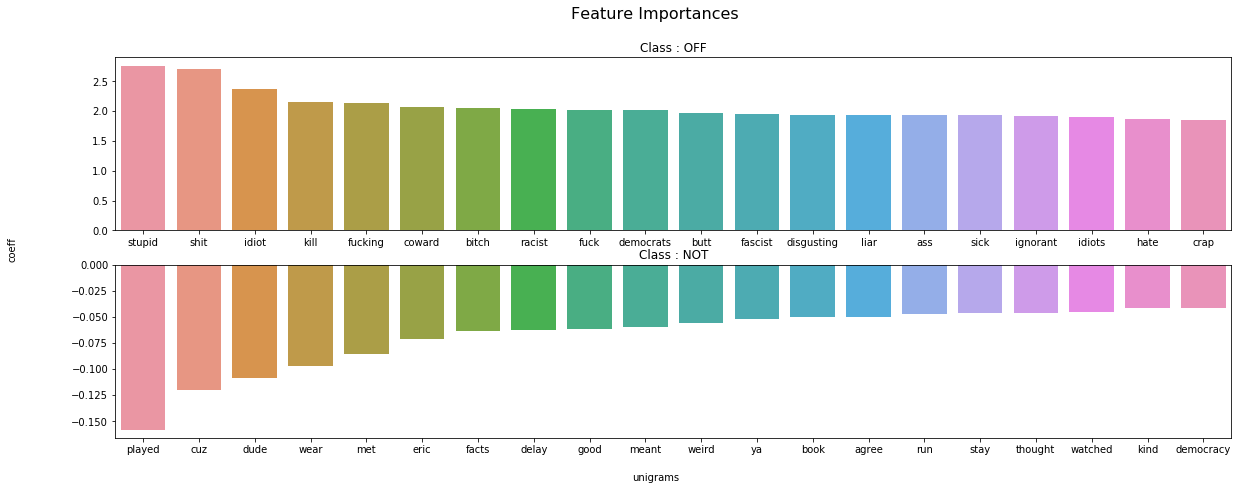

In [11]:
plot_feat_imp(modela, tfva, 'OFF', 'NOT')

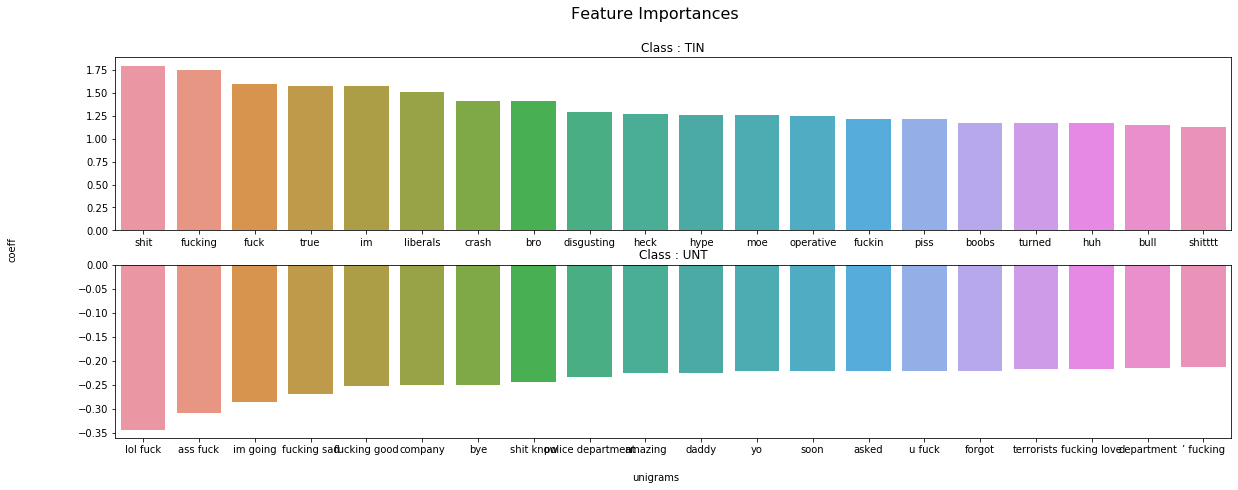

In [12]:
plot_feat_imp(modelb, tfvb, 'TIN', 'UNT')

In [13]:
# feature selection
# oversampling??